In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from __future__ import print_function
from collections import OrderedDict

import os
import sys
import timeit
import pickle

import scipy.io as sio
import numpy as np
import theano
import theano.tensor as T

#add the path of Folder Model
sys.path.insert(0, "/home/cwhuang/DVTL/Model/")
import nnet as nn
import criteria	as er
import util
import VLDF

import TwinMoonFeaturePlot as fp

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: invalid argument)


number of minibatch at one epoch: 10, batch size source : 100, target : 100 
 validation size, S:600, T:600, test size, S:400, T:400
... building the model
Encoder1_share is constructed with hidden layer number 0
Encoder1_mu is constructed with hidden layer number 0
Encoder1_sigma is constructed with hidden layer number 0
Encoder5_pi is constructed with hidden layer number 1
Encoder3_share is constructed with hidden layer number 0
Encoder3_mu is constructed with hidden layer number 0
Encoder3_sigma is constructed with hidden layer number 0
Encoder2_share is constructed with hidden layer number 0
Encoder2_mu is constructed with hidden layer number 0
Encoder2_sigma is constructed with hidden layer number 0
EncoderX_pi is constructed with hidden layer number 0
Encoder4_share is constructed with hidden layer number 0
Encoder4_mu is constructed with hidden layer number 0
Encoder4_sigma is constructed with hidden layer number 0
Decoder1_share is constructed with hidden layer number 0
Decoder

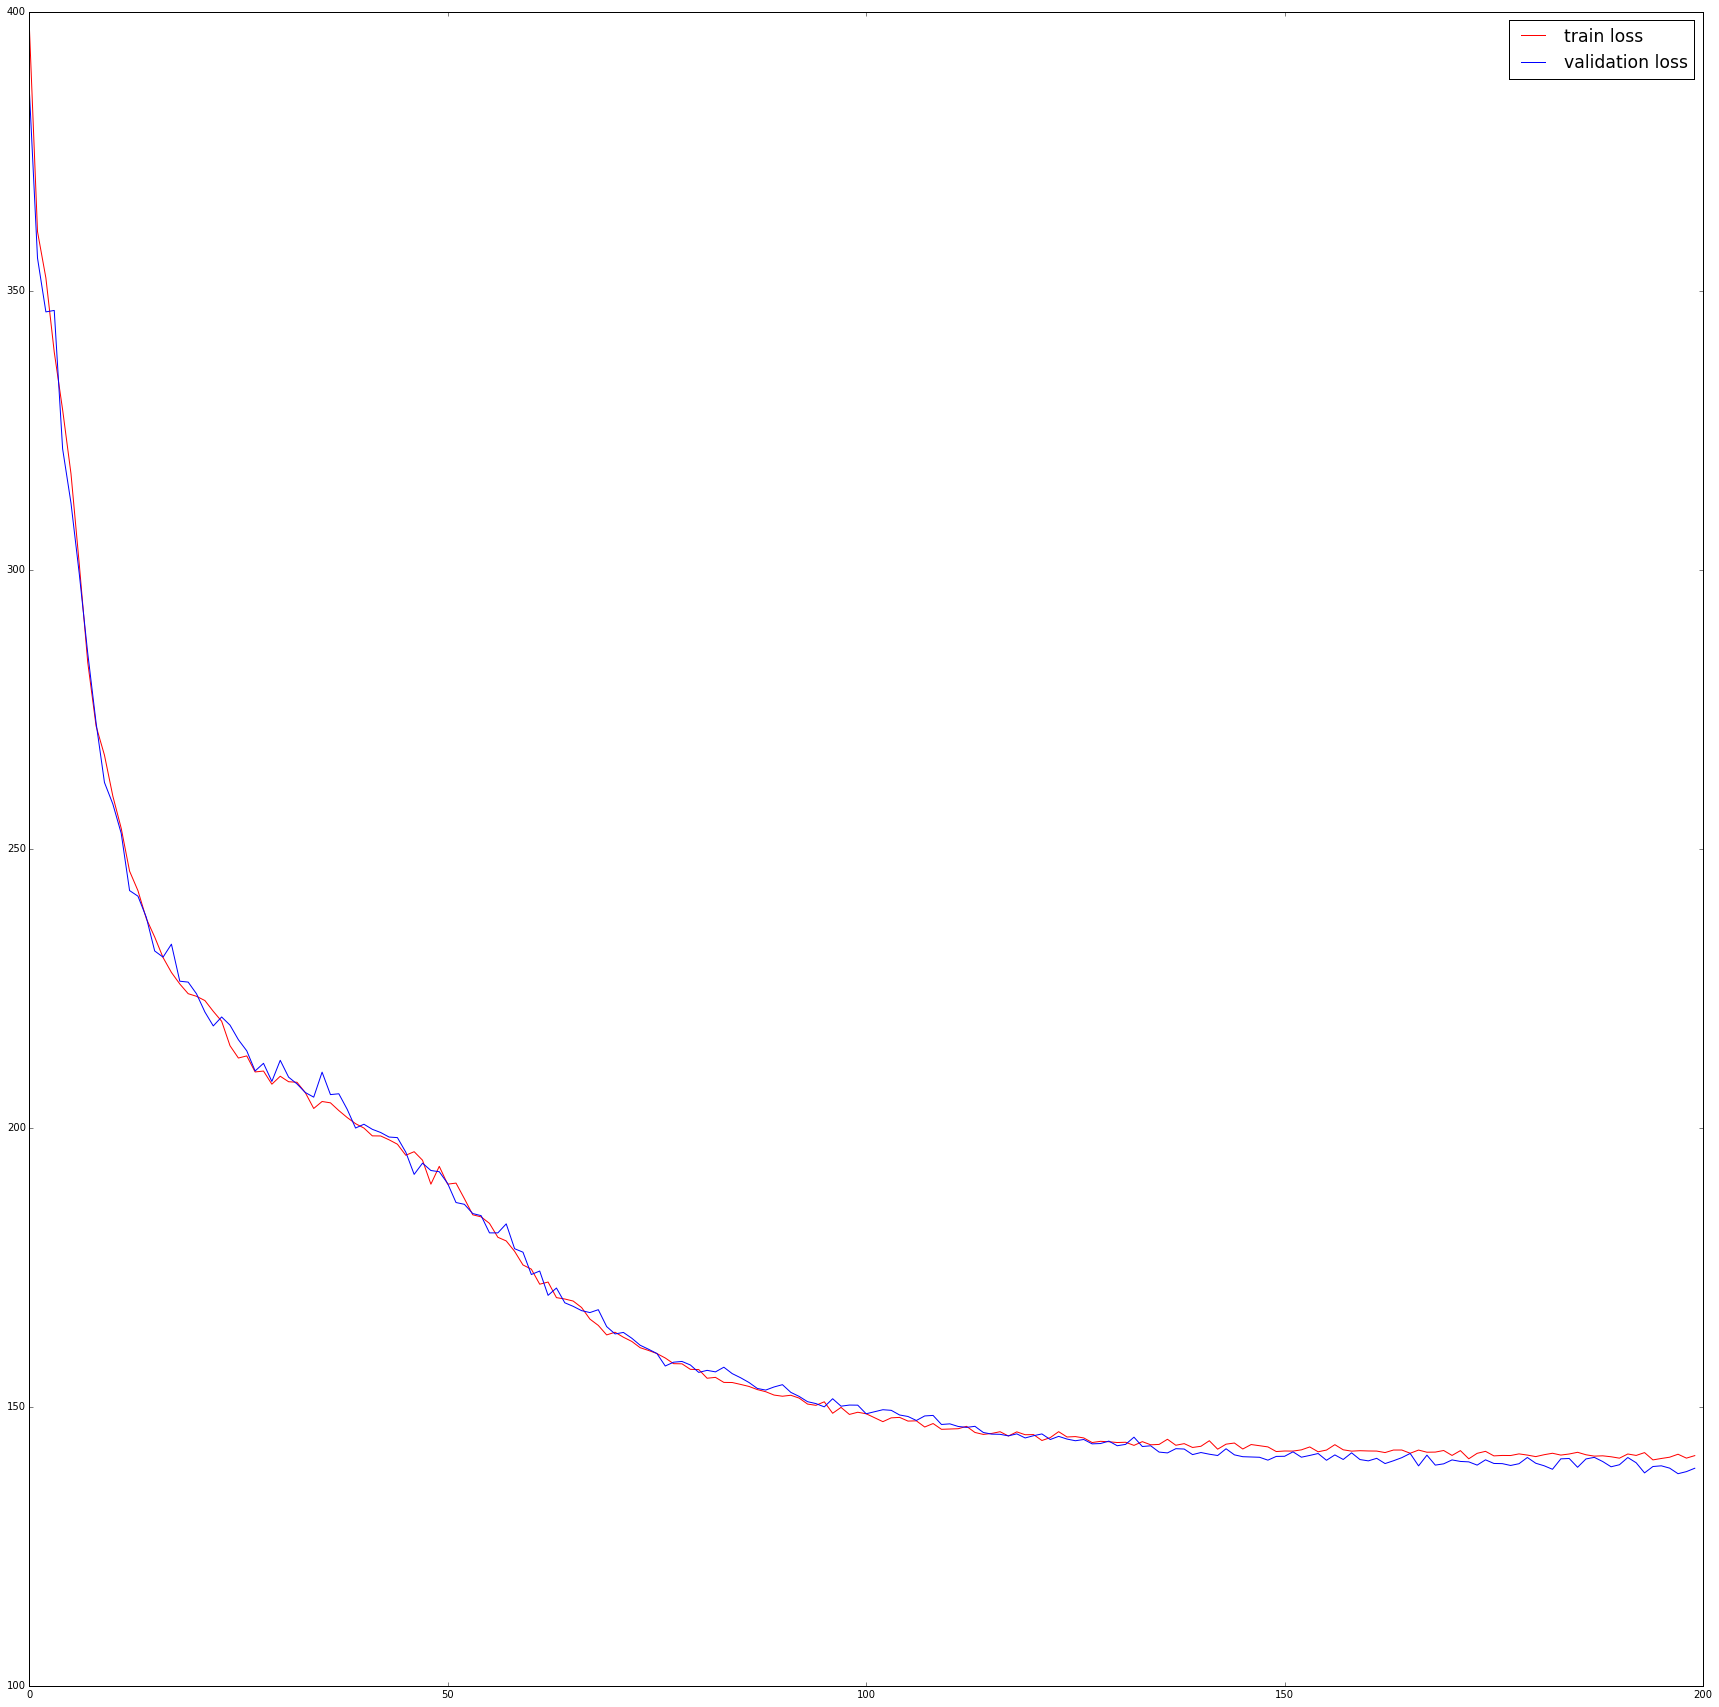

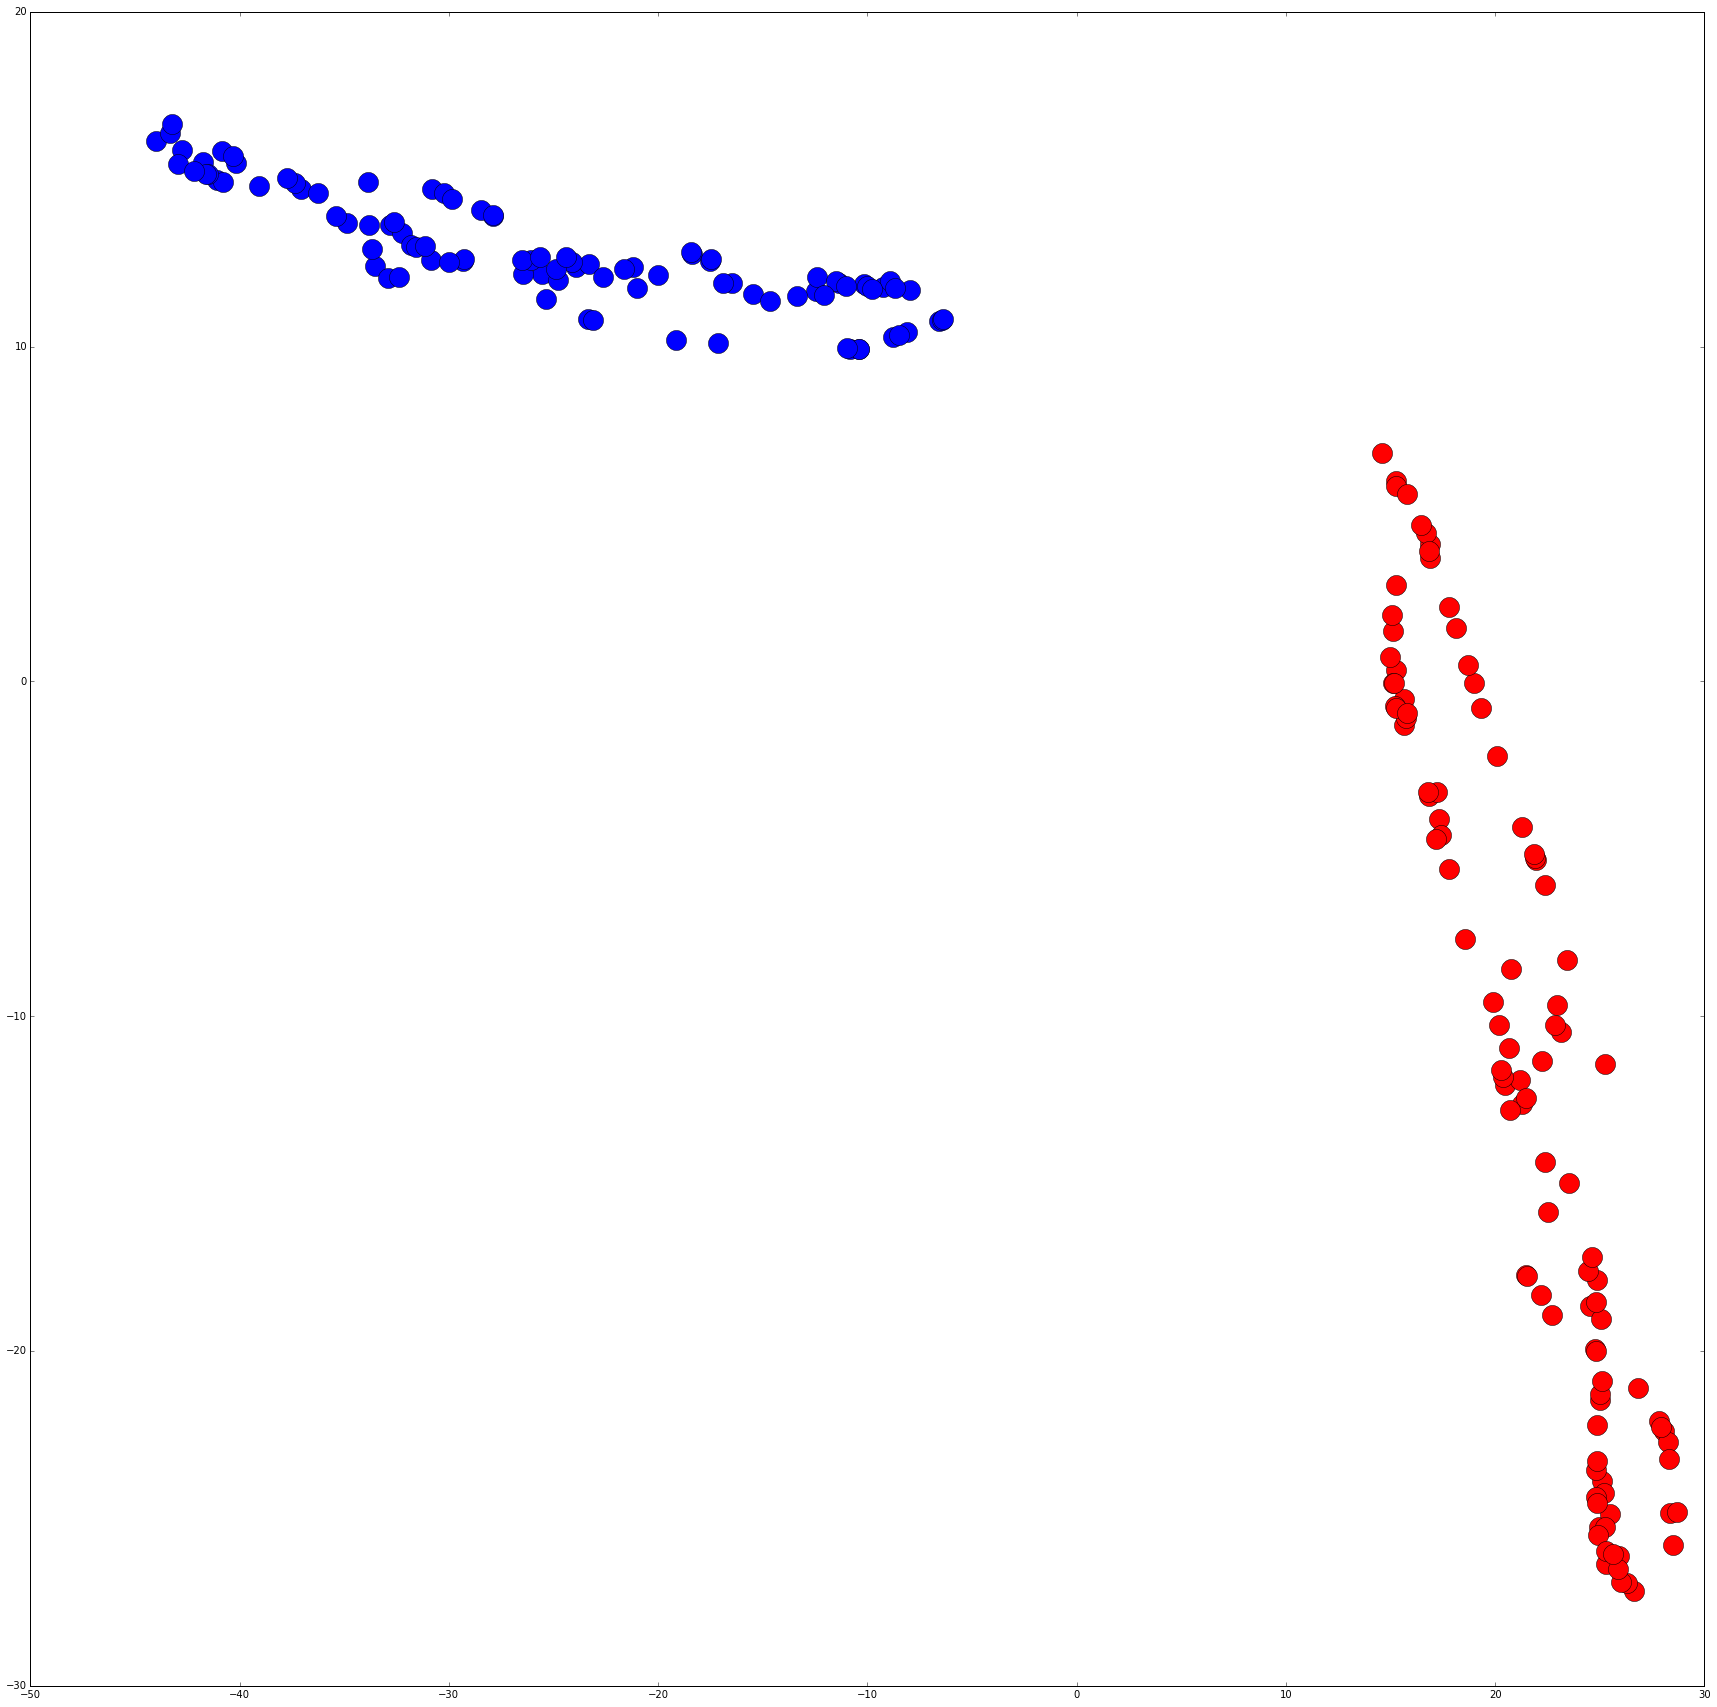

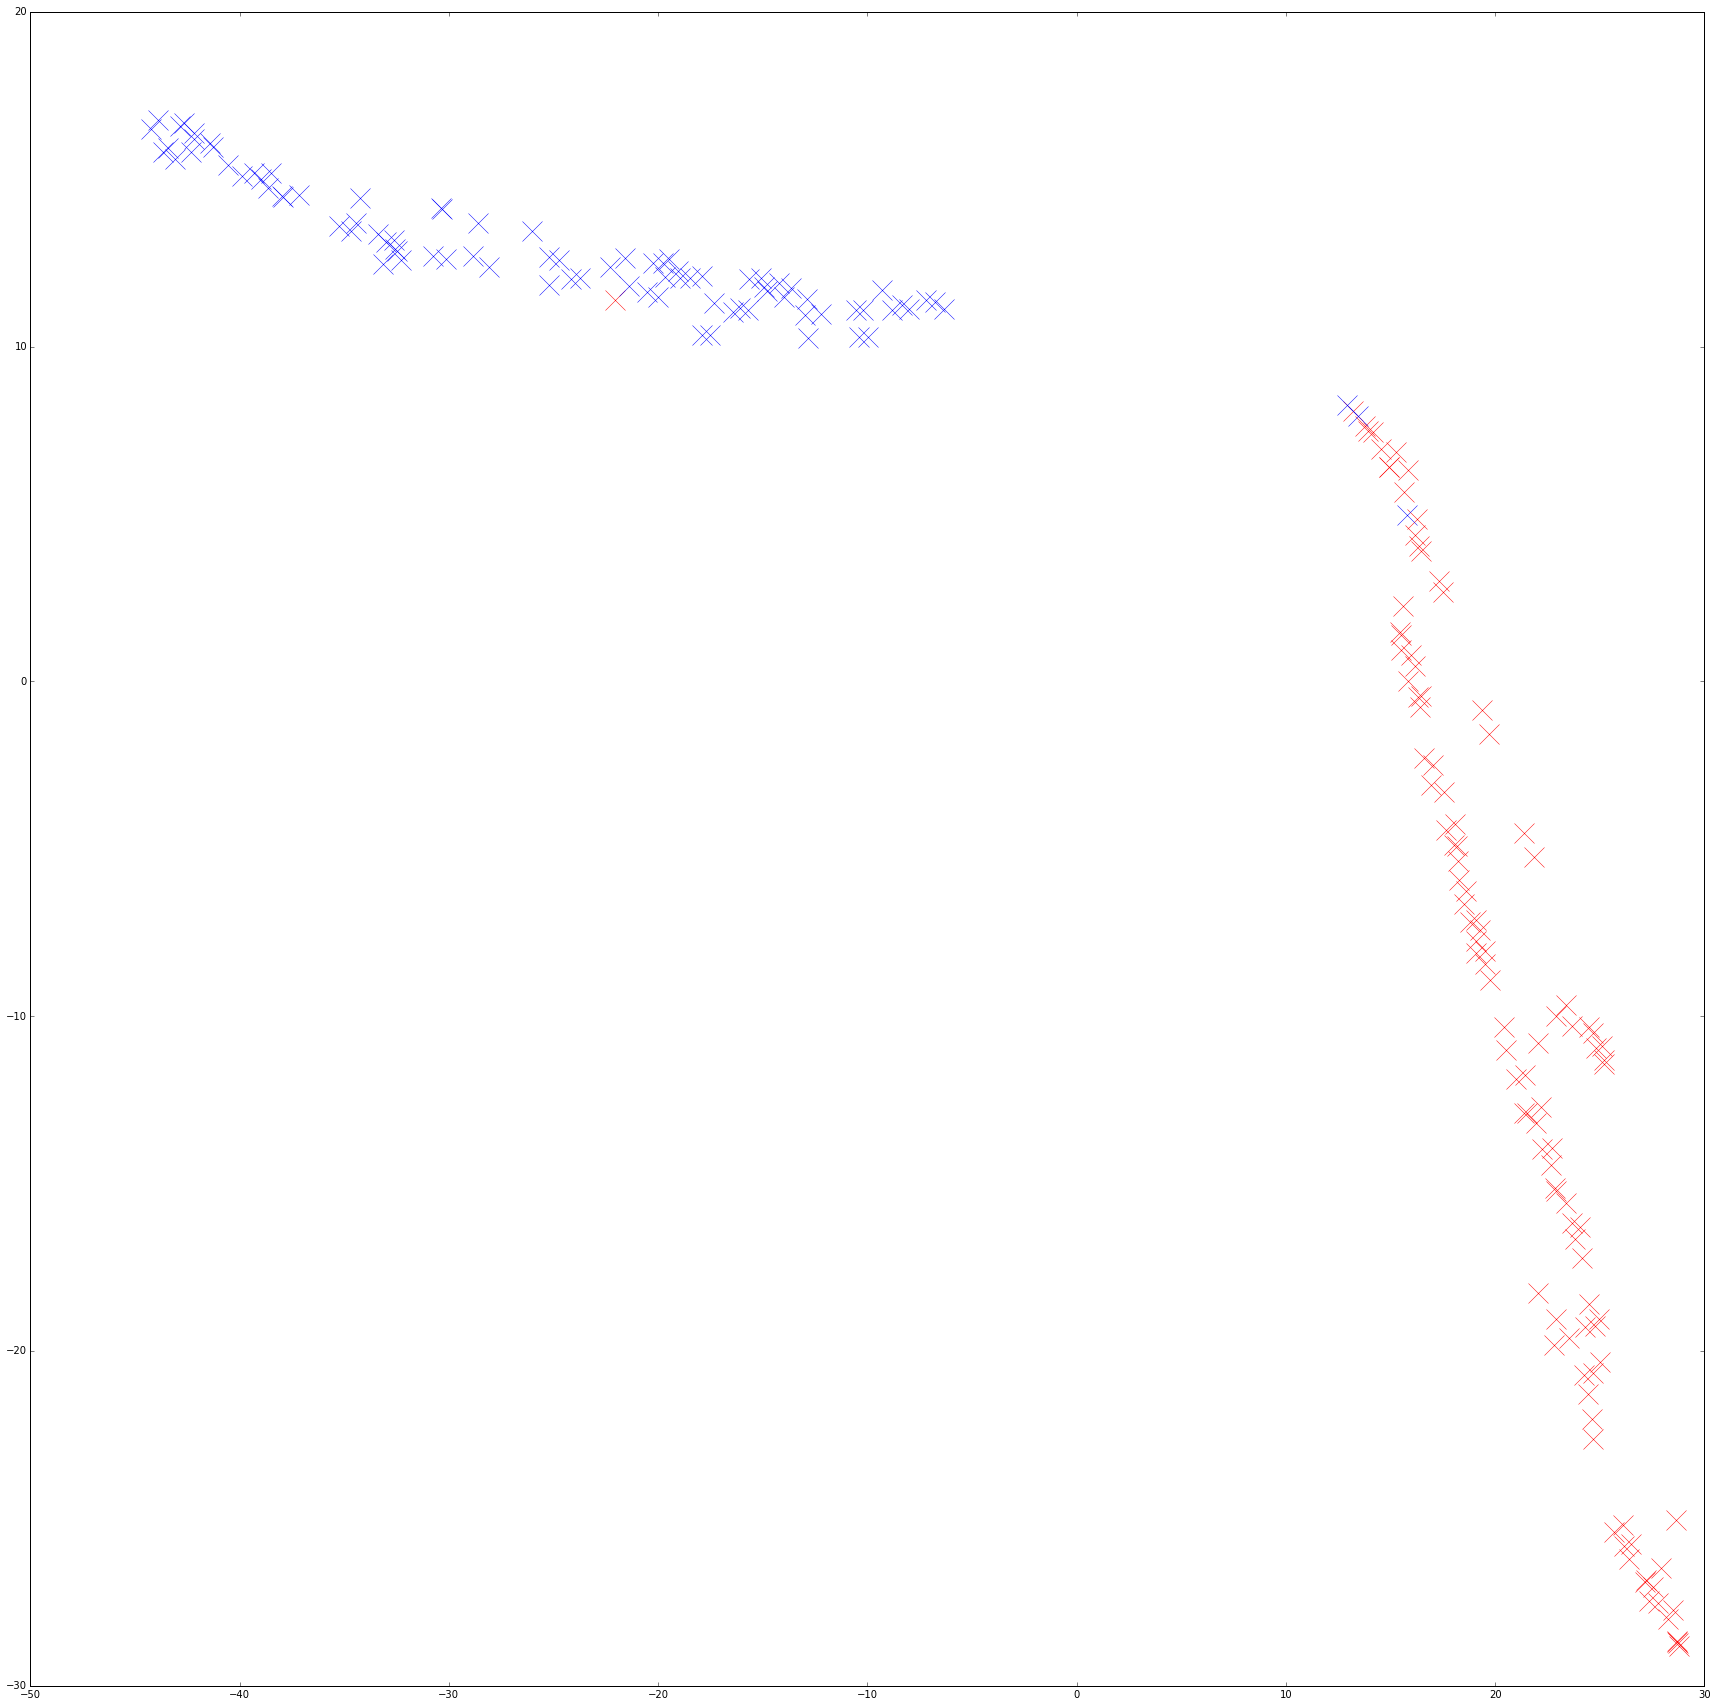

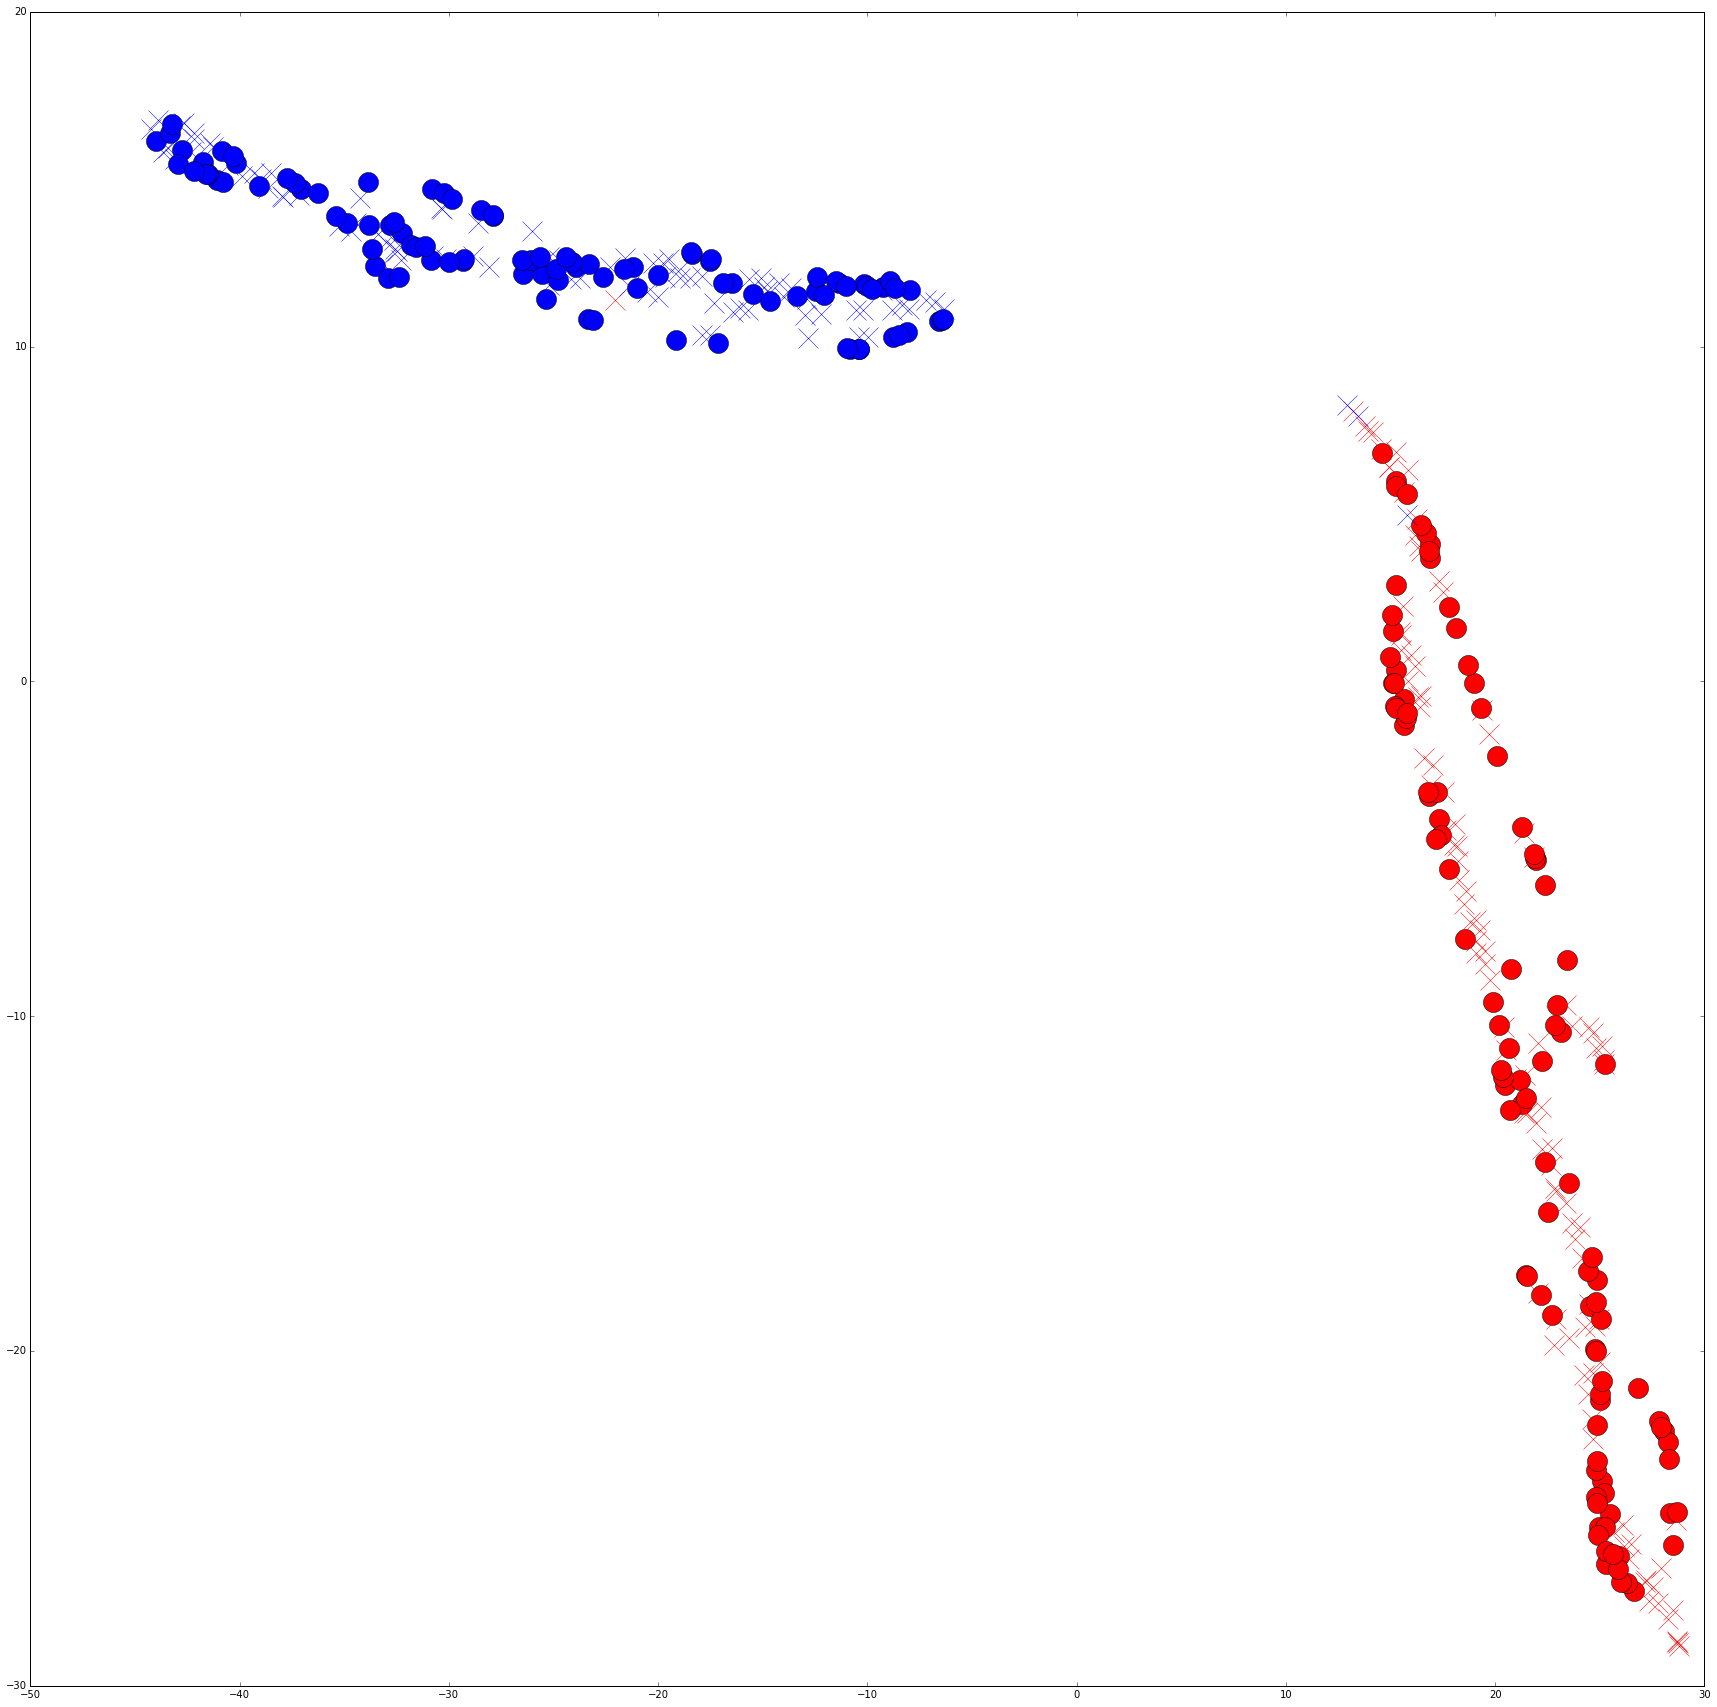

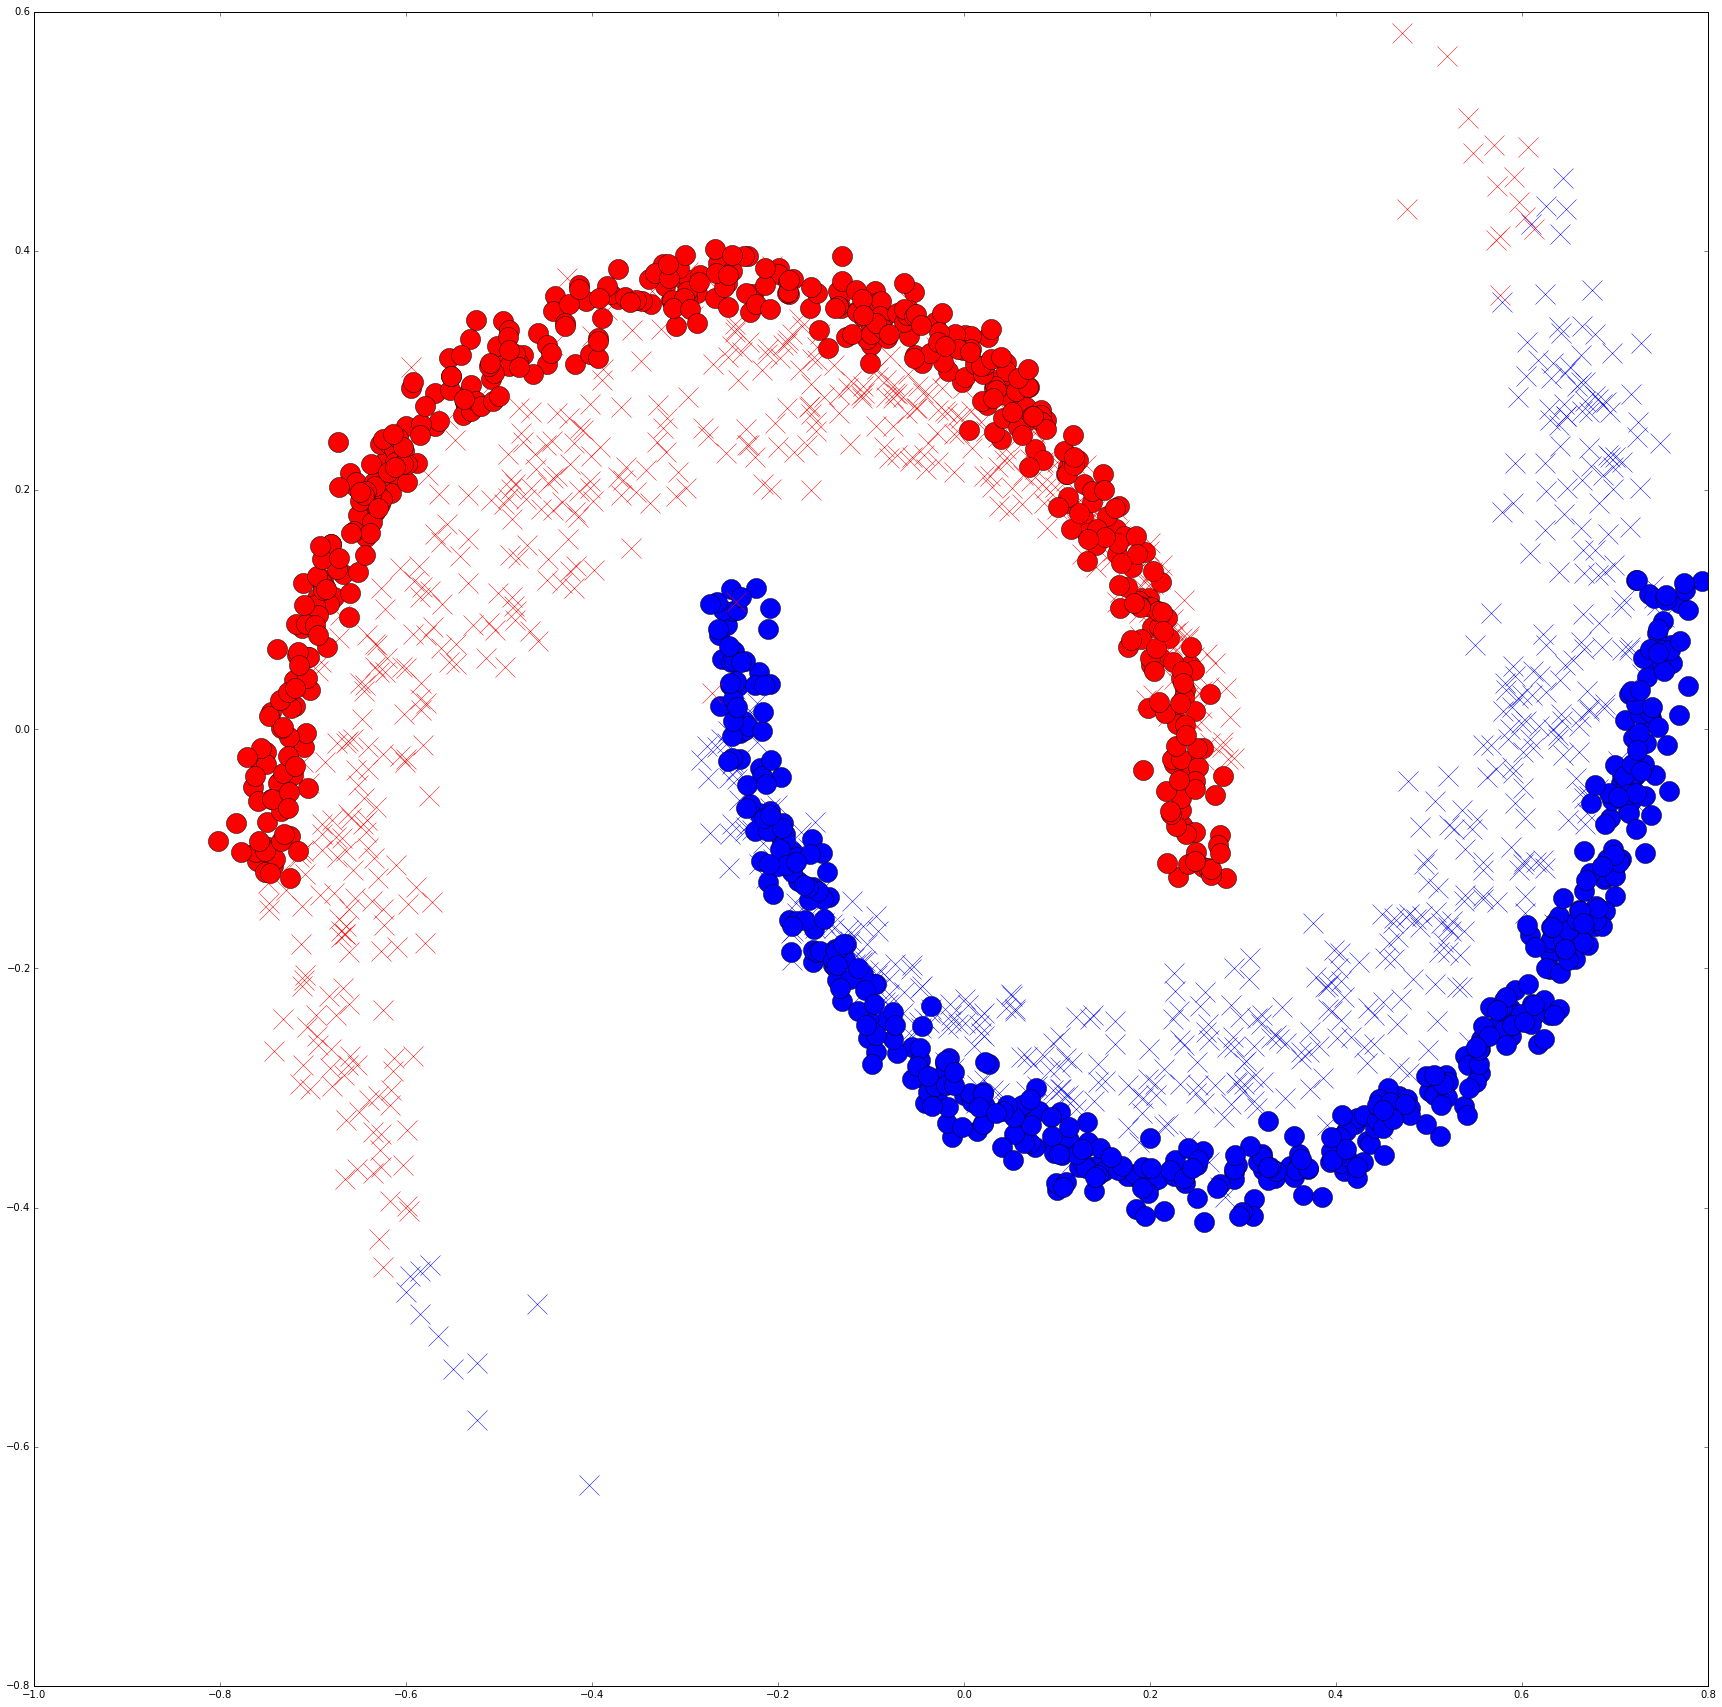

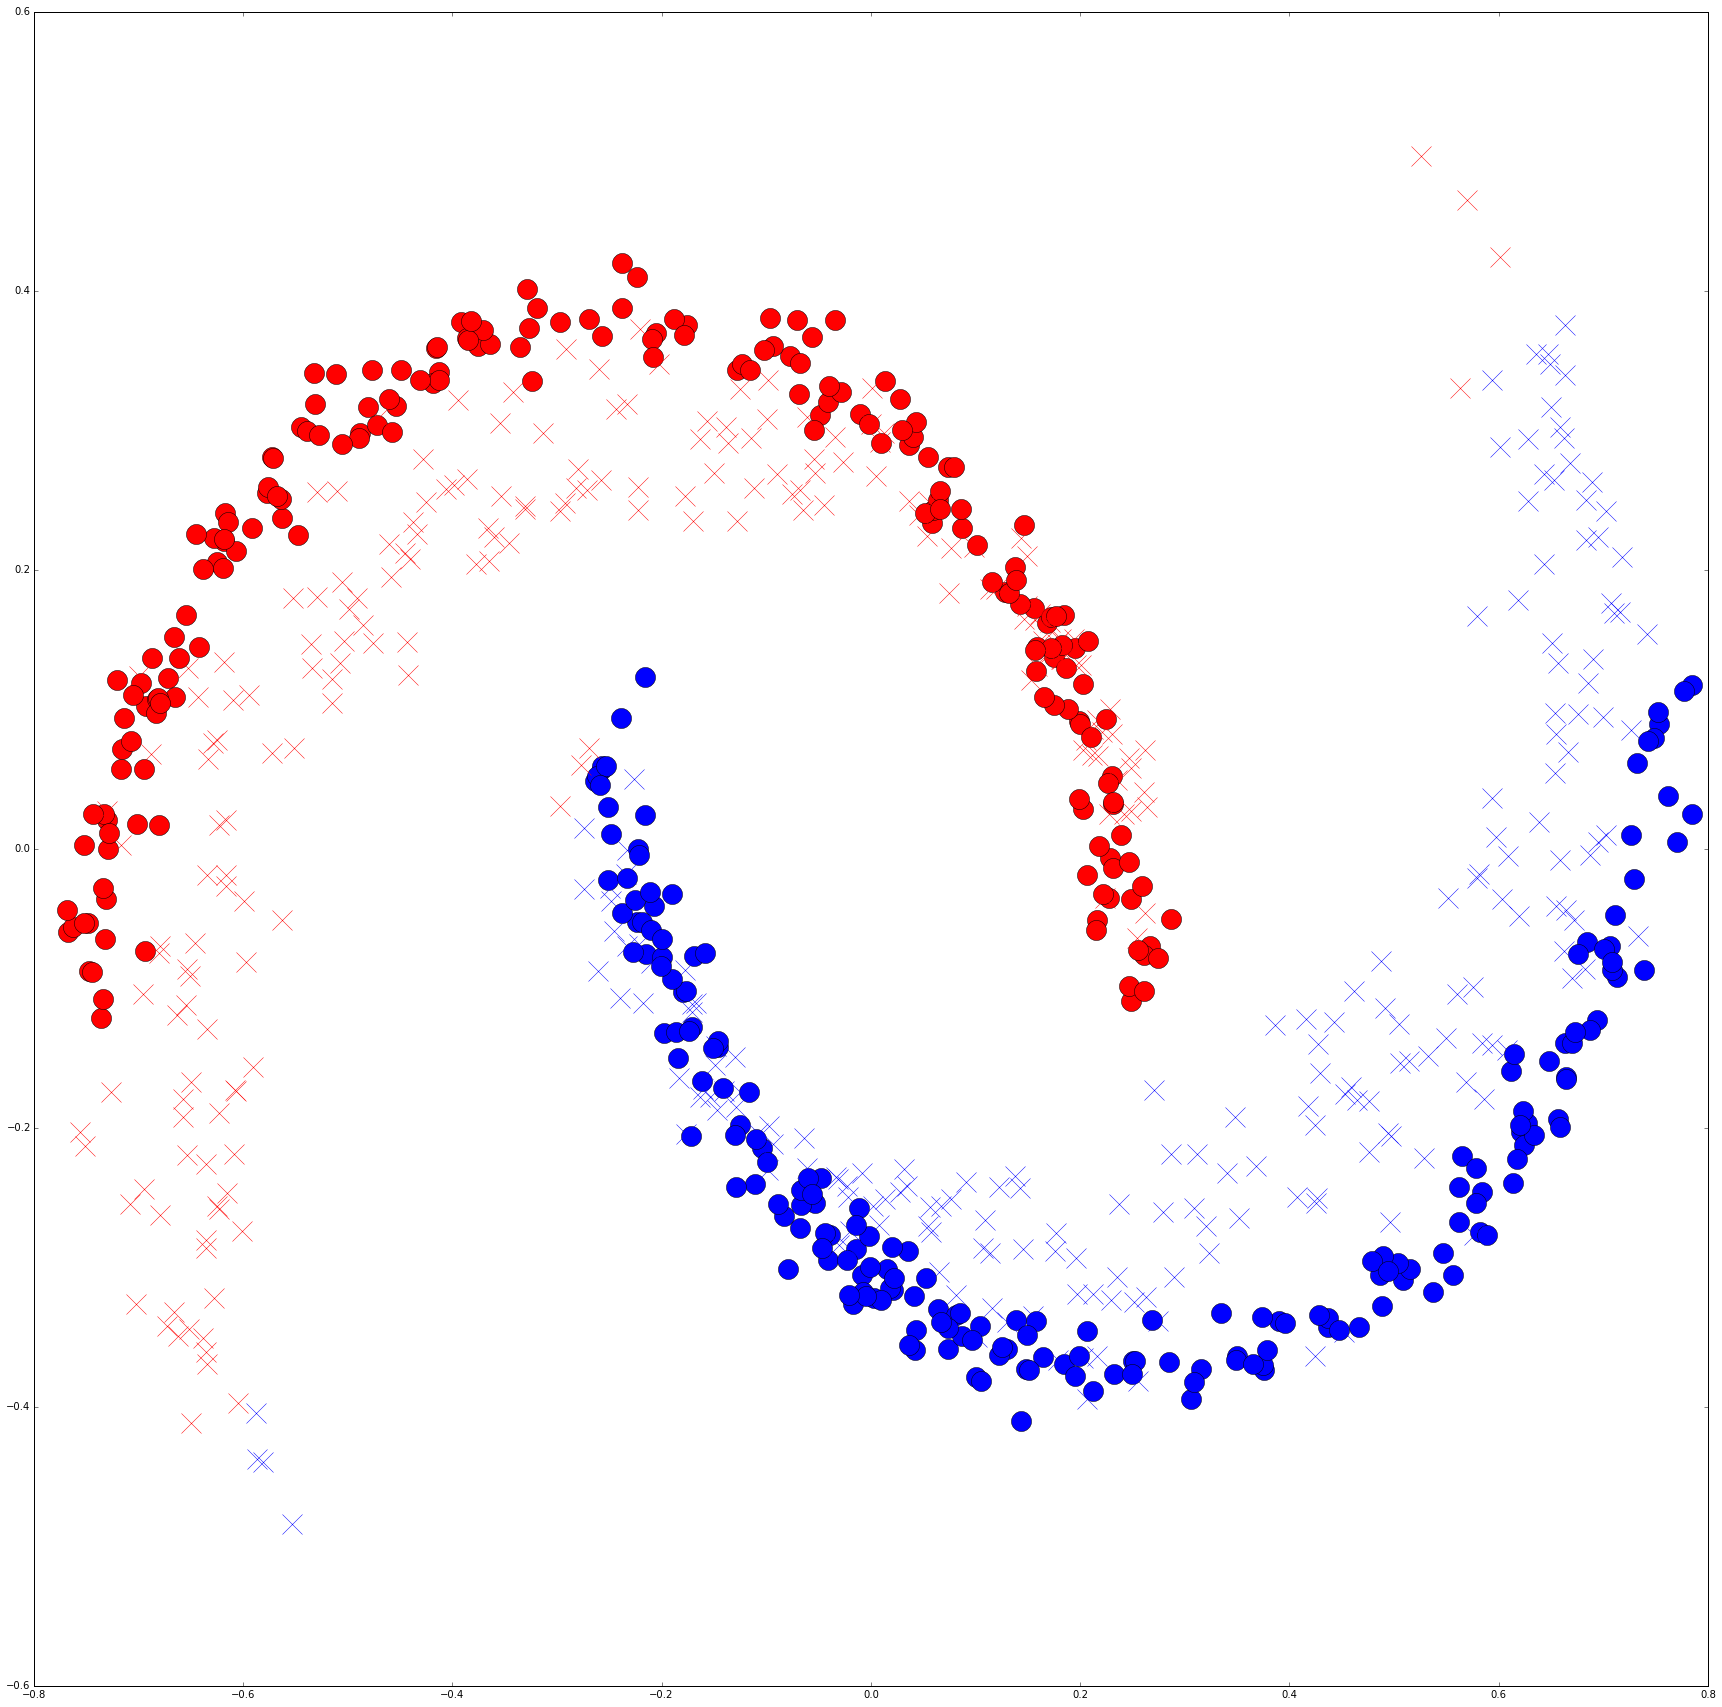

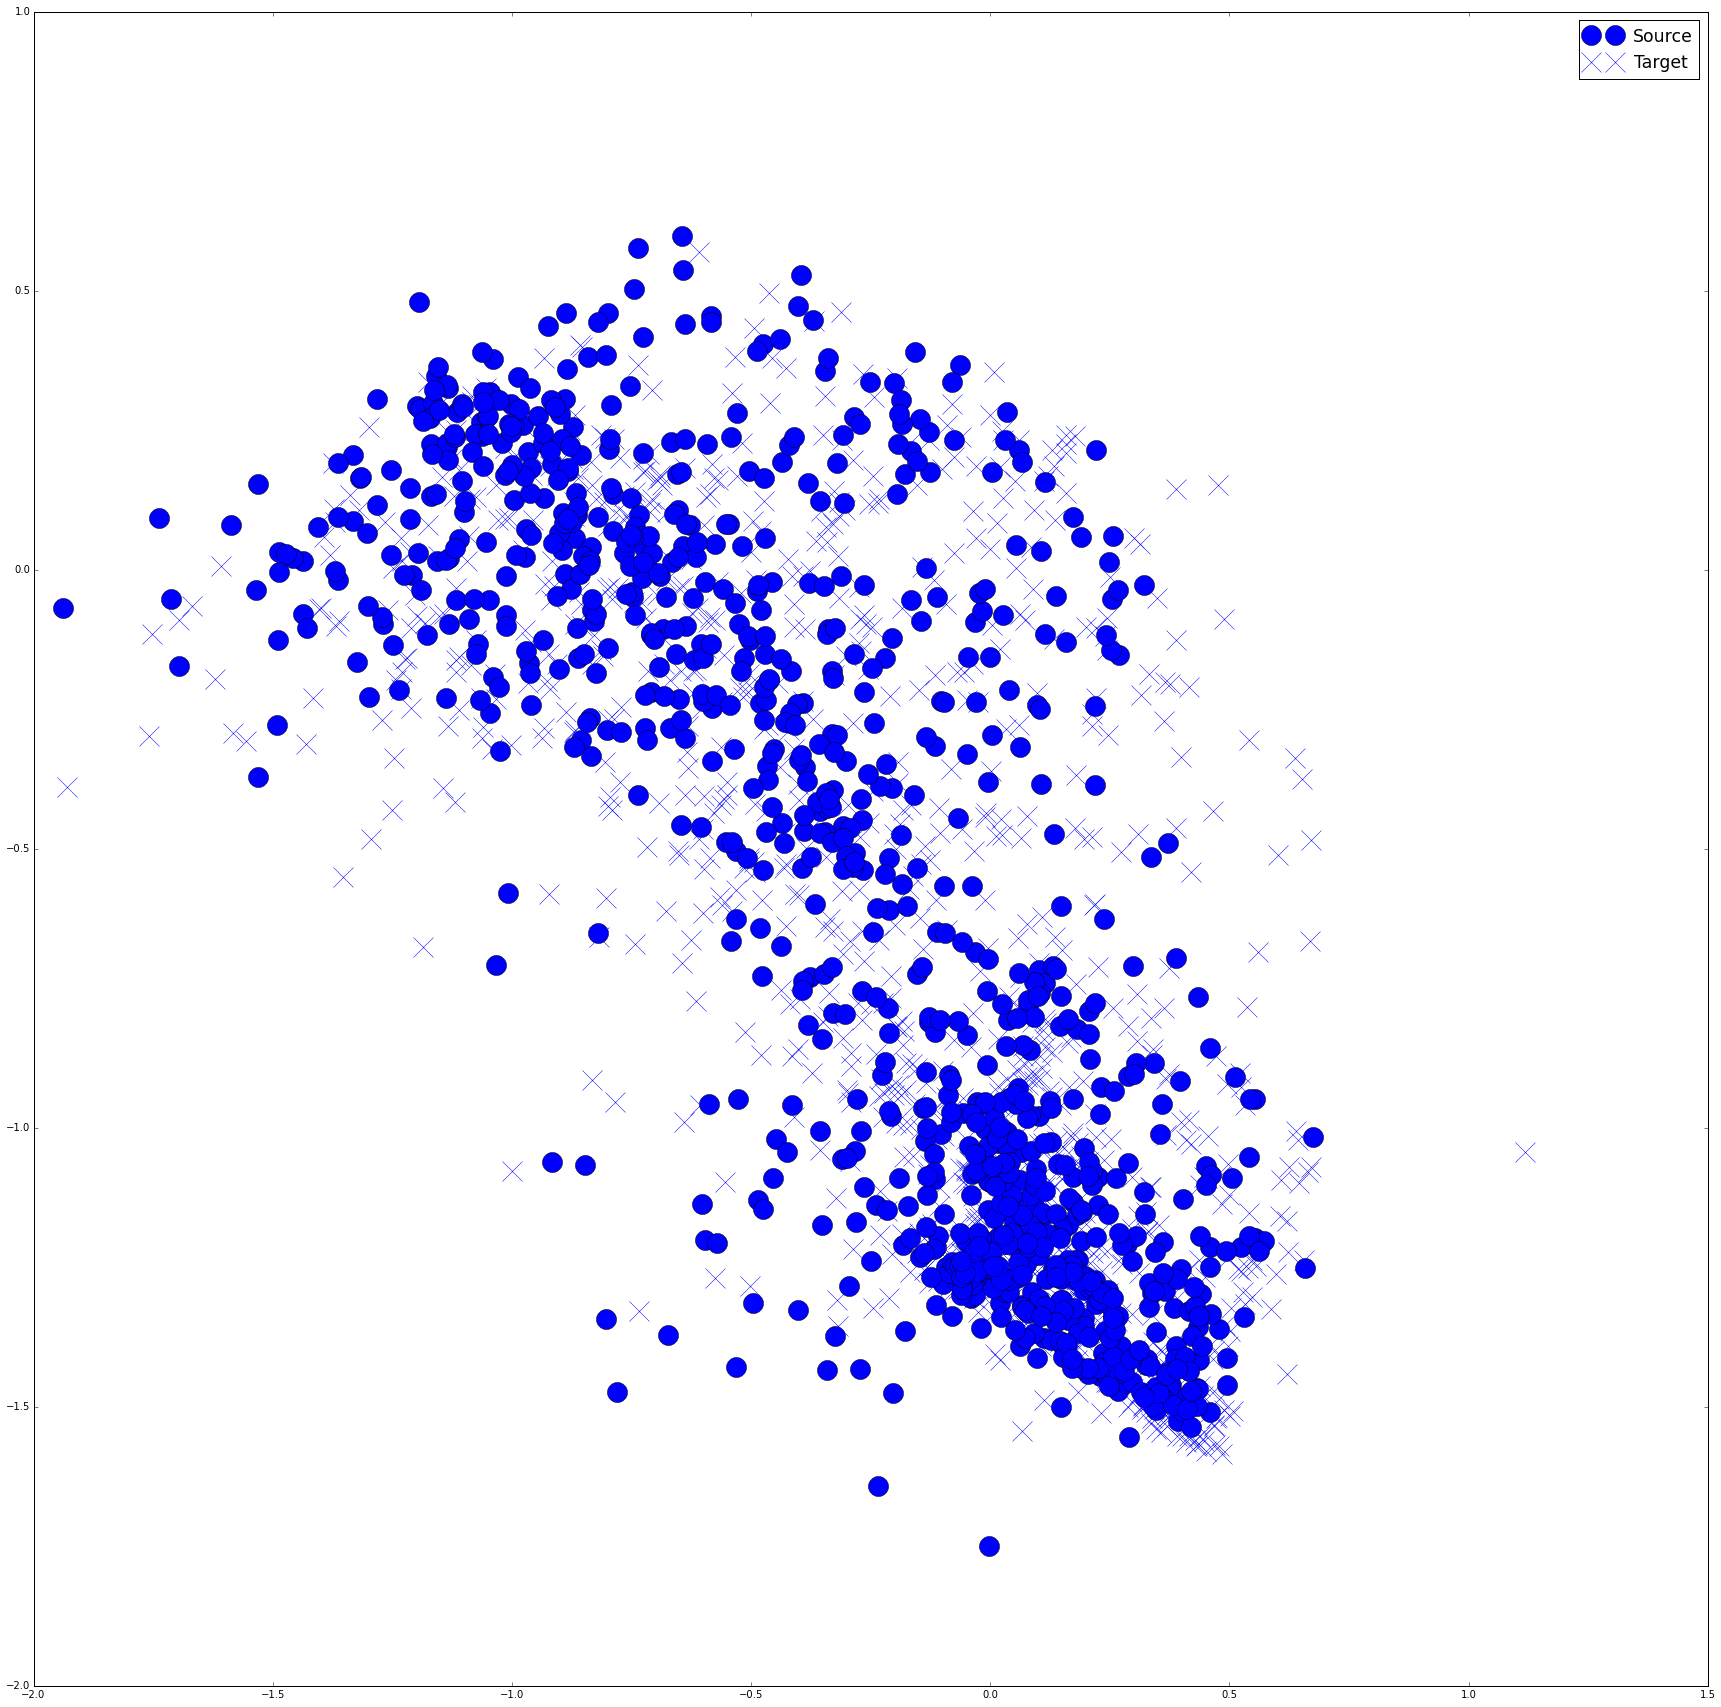

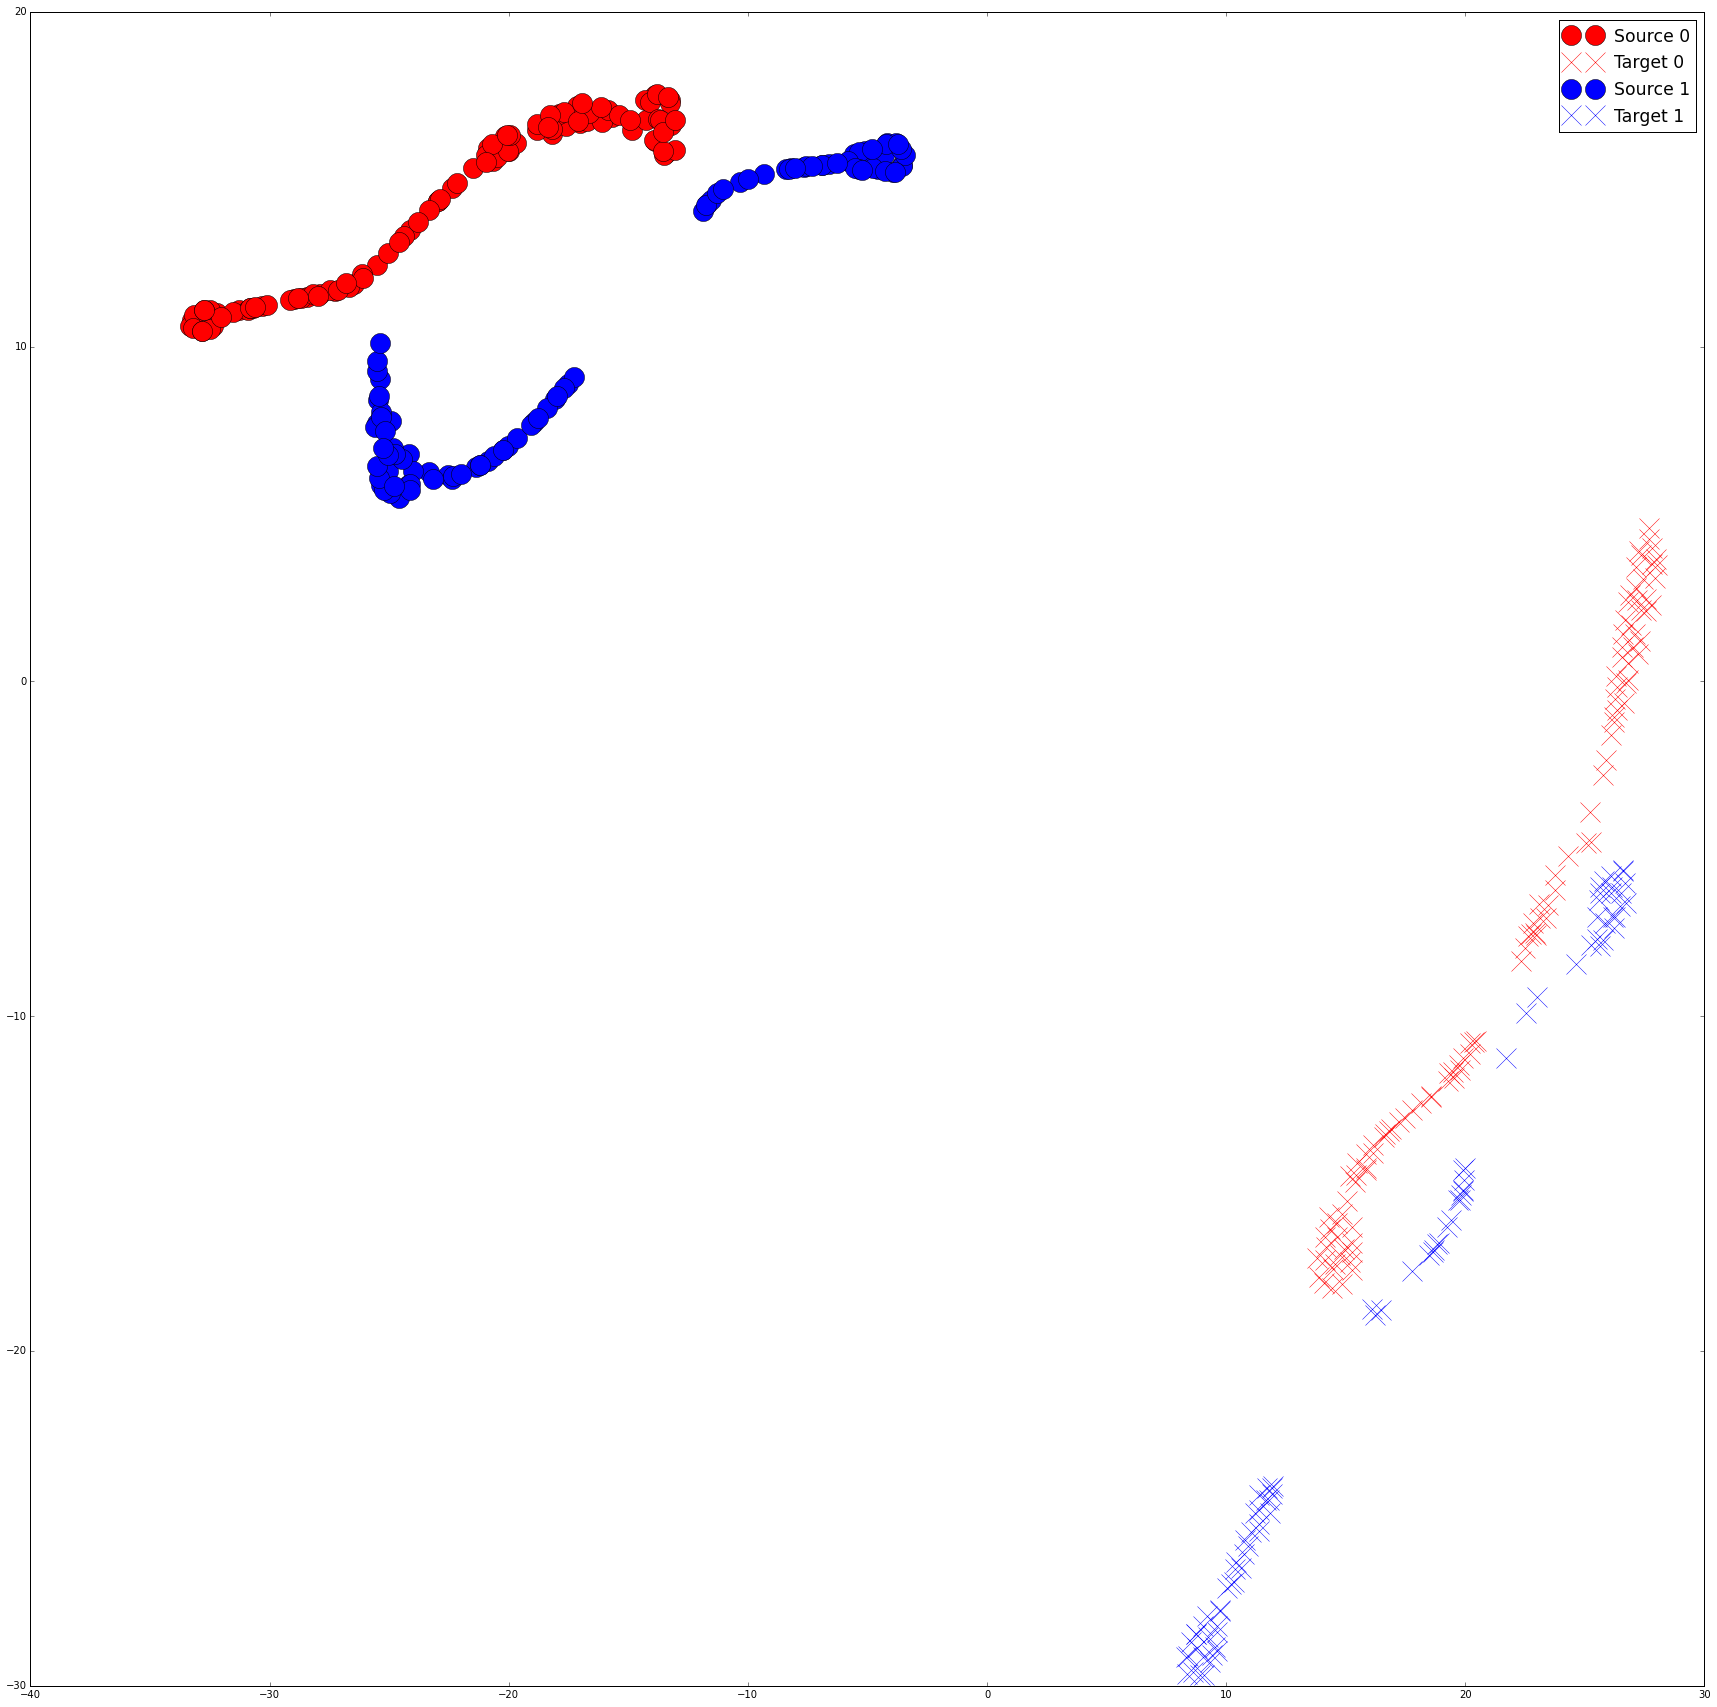

In [2]:
'''Model Construct'''
if __name__ == '__main__':
    
    file = '/home/cwhuang/DVTL/Dataset/Synthetic_Data/Twin_moon.npy'
    data = np.load(file)
    
    train_fts_source, train_labels_source = data[0]
    valid_fts_source, valid_labels_source = data[1]
    test_fts_source, test_labels_source = data[2]
    
    train_fts_target, train_labels_target = data[3]
    valid_fts_target, valid_labels_target = data[4]
    test_fts_target, test_labels_target = data[5]
    
    source_data = [(train_fts_source, train_labels_source), (valid_fts_source, valid_labels_source), (test_fts_source, test_labels_source)]
    target_data = [(train_fts_target, train_labels_target), (valid_fts_target, valid_labels_target), (test_fts_target, test_labels_target)]    
    
    ########################################################################
    ###                        Coefficient Initial                       ###
    ########################################################################           

    x_dim = 2
    y_dim = 2    
    d_dim = 2    
    z_dim = 5                #dimension of latent feature
    a_dim = 2               #dimension of prior of latent feature    
    h_z_dim = 10             #dimension of hidden unit  
    h_a_dim = 5
    h_y_dim = 5
    learning_rate = 0.01
    activation = T.nnet.sigmoid

    
    struct = VLDF.VLDF_struct()    
    encoder_template = nn.NN_struct()
    
    struct.encoder1.share.layer_dim = [x_dim+d_dim, h_z_dim]
    struct.encoder1.share.activation = [activation]
    struct.encoder1.share.learning_rate = [learning_rate, learning_rate]
    struct.encoder1.share.decay = [1, 1]                
    struct.encoder1.mu.layer_dim = [h_z_dim, z_dim]
    struct.encoder1.mu.activation = [None]
    struct.encoder1.mu.learning_rate = [learning_rate]
    struct.encoder1.mu.decay = [1]      
    struct.encoder1.sigma.layer_dim = [h_z_dim, z_dim]
    struct.encoder1.sigma.activation = [None]
    struct.encoder1.sigma.learning_rate = [learning_rate]
    struct.encoder1.sigma.decay = [1]   

    struct.encoder2.share.layer_dim = [x_dim+d_dim, h_z_dim]
    struct.encoder2.share.activation = [activation]
    struct.encoder2.share.learning_rate = [learning_rate, learning_rate]
    struct.encoder2.share.decay = [1, 1]                
    struct.encoder2.mu.layer_dim = [h_z_dim, z_dim]
    struct.encoder2.mu.activation = [None]
    struct.encoder2.mu.learning_rate = [learning_rate]
    struct.encoder2.mu.decay = [1]      
    struct.encoder2.sigma.layer_dim = [h_z_dim, z_dim]
    struct.encoder2.sigma.activation = [None]
    struct.encoder2.sigma.learning_rate = [learning_rate]
    struct.encoder2.sigma.decay = [1]     
    
    struct.encoder3.share.layer_dim = [z_dim+y_dim, h_a_dim]
    struct.encoder3.share.activation = [activation]
    struct.encoder3.share.learning_rate = [learning_rate]
    struct.encoder3.share.decay = [1]                
    struct.encoder3.mu.layer_dim = [h_a_dim, a_dim]
    struct.encoder3.mu.activation = [None]
    struct.encoder3.mu.learning_rate = [learning_rate]
    struct.encoder3.mu.decay = [1]      
    struct.encoder3.sigma.layer_dim = [h_a_dim, a_dim]
    struct.encoder3.sigma.activation = [None]
    struct.encoder3.sigma.learning_rate = [learning_rate]
    struct.encoder3.sigma.decay = [1]

    struct.encoder4.share.layer_dim = [z_dim+d_dim, h_a_dim]
    struct.encoder4.share.activation = [activation]
    struct.encoder4.share.learning_rate = [learning_rate]
    struct.encoder4.share.decay = [1]                
    struct.encoder4.mu.layer_dim = [h_a_dim, a_dim]
    struct.encoder4.mu.activation = [None]
    struct.encoder4.mu.learning_rate = [learning_rate]
    struct.encoder4.mu.decay = [1]      
    struct.encoder4.sigma.layer_dim = [h_a_dim, a_dim]
    struct.encoder4.sigma.activation = [None]
    struct.encoder4.sigma.learning_rate = [learning_rate]
    struct.encoder4.sigma.decay = [1]    
    
    struct.encoder5.layer_dim = [z_dim, h_y_dim, y_dim]
    struct.encoder5.activation = [activation, T.nnet.softmax]   
    struct.encoder5.learning_rate = [learning_rate, learning_rate]
    struct.encoder5.decay = [1, 1]     

    struct.encoderX.layer_dim = [z_dim, d_dim]
    struct.encoderX.activation = [T.nnet.softmax]   
    struct.encoderX.learning_rate = [learning_rate, learning_rate]
    struct.encoderX.decay = [1, 1]     
    
   
    struct.decoder1.share.layer_dim = [z_dim+z_dim, h_z_dim]
    struct.decoder1.share.activation = [activation]
    struct.decoder1.share.learning_rate = [learning_rate]
    struct.decoder1.share.decay = [1]                
    struct.decoder1.mu.layer_dim = [h_z_dim, x_dim]
    struct.decoder1.mu.activation = [None]
    struct.decoder1.mu.learning_rate = [learning_rate]
    struct.decoder1.mu.decay = [1]      
    struct.decoder1.sigma.layer_dim = [h_z_dim, x_dim]
    struct.decoder1.sigma.activation = [None]
    struct.decoder1.sigma.learning_rate = [learning_rate]
    struct.decoder1.sigma.decay = [1]      
    
    struct.decoder2.share.layer_dim = [a_dim+y_dim, h_a_dim]
    struct.decoder2.share.activation = [activation]
    struct.decoder2.share.learning_rate = [learning_rate]
    struct.decoder2.share.decay = [1]                
    struct.decoder2.mu.layer_dim = [h_a_dim, z_dim]
    struct.decoder2.mu.activation = [None]
    struct.decoder2.mu.learning_rate = [learning_rate]
    struct.decoder2.mu.decay = [1]      
    struct.decoder2.sigma.layer_dim = [h_a_dim, z_dim]
    struct.decoder2.sigma.activation = [None]
    struct.decoder2.sigma.learning_rate = [learning_rate]
    struct.decoder2.sigma.decay = [1]      

    struct.decoder3.share.layer_dim = [a_dim+d_dim, h_a_dim]
    struct.decoder3.share.activation = [activation]
    struct.decoder3.share.learning_rate = [learning_rate]
    struct.decoder3.share.decay = [1]                
    struct.decoder3.mu.layer_dim = [h_a_dim, z_dim]
    struct.decoder3.mu.activation = [None]
    struct.decoder3.mu.learning_rate = [learning_rate]
    struct.decoder3.mu.decay = [1]      
    struct.decoder3.sigma.layer_dim = [h_a_dim, z_dim]
    struct.decoder3.sigma.activation = [None]
    struct.decoder3.sigma.learning_rate = [learning_rate]
    struct.decoder3.sigma.decay = [1]     
    
    coef = VLDF.VLDF_coef(
        alpha = 1000,
        beta = 100,
        chi = 1,
        gamma = 0,
        D = 100,
        L = 1,
        optimize = 'Adam_update'        
    )    
    
    isMMD = 'MMD_'
    if coef.beta == 0:
        isMMD = ''                
    description = 'TwinMoonSp_VLDF_%s%s' % (isMMD, coef.optimize)        
    
    features_model, test_model, trained_param = VLDF.VLDF_training(
        source_data = source_data,
        target_data = target_data,
        n_train_batches=10,
        n_epochs=200,
        struct = struct,
        coef = coef,
        description = description
    )
    
    sample_n = 200
    fp.features_plot(features_model, test_model, source_data, target_data, sample_n, description, reconstruction=True)
    
    #print('-------------------------------------------------------------------------')
    
    zd_S = features_model()[6][0:sample_n,:]
    zd_T = features_model()[7][0:sample_n,:]
    
    zd_S, zd_T = util.feature_tsne(zd_S, zd_T)
    
    label_zd_S = []
    label_zd_T = []
    
    for i in range(y_dim):
        label_zd_S.append( zd_S[np.where(train_labels_source[0:sample_n,i] == 1)[0], :] )
        label_zd_T.append( zd_T[np.where(train_labels_target[0:sample_n,i] == 1)[0], :] )  
        
    title = 'Zd_feature_%s' % (description)
    fts = (label_zd_S[0][:,0], label_zd_S[0][:,1], label_zd_T[0][:,0], label_zd_T[0][:,1],
           label_zd_S[1][:,0], label_zd_S[1][:,1], label_zd_T[1][:,0], label_zd_T[1][:,1])    
    label = ('Source 0', 'Target 0', 'Source 1', 'Target 1')
    color = [1, 1, 2, 2]
    marker = [1, 2, 1, 2]
    line = False    
    legend = True
    util.data2plot(title=title, fts=fts, label=label, color=color, marker=marker, line=line, legend=legend)          